# One-Class SVM

## Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv("../data/processed_train_df.csv")
print(train_df.shape)

test_df = pd.read_csv("../data/processed_test_df.csv")
print(test_df.shape)

df = pd.concat([train_df, test_df])
print(df.shape)

(227845, 31)
(56962, 31)
(284807, 31)


In [2]:
# Exclude labels

y_train = train_df['Class']
X_train = train_df.drop(columns=['Class'])

y_test = test_df['Class']
X_test = test_df.drop(columns=['Class'])

labels = df['Class']
df_unlabelled = df.drop(columns=['Class'])

In [3]:
from sklearn.model_selection import train_test_split

# Build a validation with 20% of the data (25% of the train dataset)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

## Model Building

In [4]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(
    kernel="rbf",
    gamma="scale",  # or tune numeric values
    nu=0.01,         # expected outlier fraction
)
ocsvm.fit(X_train)

OneClassSVM(nu=0.01)

In [5]:
scores = -ocsvm.decision_function(X_test).ravel()
pred_labels = (ocsvm.predict(X_test) == -1).astype(int)

ROC: 0.9303
PR AUC: 0.0899


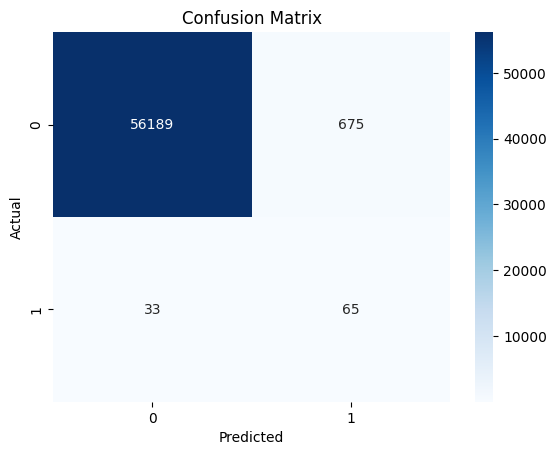

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

roc = roc_auc_score(y_test, scores)
pr_auc = average_precision_score(y_test, scores)

print(f"ROC: {roc.round(4)}")
print(f"PR AUC: {pr_auc.round(4)}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

This model is ok, but let's see if we can improve it with some tuning.

## Hyperparamater Tuning

In [6]:
# Find a good random_state so that the sample mean is close to the actual mean

mean = 0
i = 0

while abs(mean-0.00172) > 0.00005:
    i+=1
    train_sample = train_df.sample(frac=0.2, random_state=i)
    X_sample = train_sample.drop(columns=['Class'])
    y_sample = train_sample['Class']
    mean = y_sample.mean()

print(i)
print(mean)

2
0.0017336347078057452


In [7]:
import numpy as np

def precision_recall_at_k(y_true, scores, k=0.01):
    """
    Compute Precision@k and Recall@k for anomaly scores.
    y_true: array-like of shape (n,) with 0/1 labels
    scores: array-like of shape (n,) with higher = more anomalous
    k: fraction of samples to flag (e.g. 0.01 = top 1%)
    """
    n = len(scores)
    top_n = max(1, int(np.ceil(k * n)))  # at least one sample

    # Get indices of top-k scores
    idx = np.argsort(-scores)[:top_n]

    # Precision = frauds / flagged
    precision = y_true.iloc[idx].mean()

    # Recall = frauds caught / total frauds
    recall = y_true.iloc[idx].sum() / y_true.sum()

    return precision, recall

In [13]:
# First tune on a sample of the train dataset

from sklearn.model_selection import ParameterGrid

PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

# Note that I have already narrowed down the param_grid through multiple iterations

param_grid = {
    "nu": [0.02, 0.03, 0.04, 0.05],
    "gamma": ["scale", 0.01, 0.02] # Note that 'scale' and 'auto' are roughly equivalent since the features are scaled --> they have variance 1. Both are ~= 0.03.
}

runs = []
best_tuple = (-np.inf, -np.inf)
best_params, best_model, best_scores = None, None, None

for params in ParameterGrid(param_grid):
    ocsvm = OneClassSVM(
        kernel="rbf",
        **params
    )
    ocsvm.fit(X_sample)
    scores = -ocsvm.decision_function(X_val)

    roc = roc_auc_score(y_val, scores)
    pr_auc = average_precision_score(y_val, scores)
    p_at_1,  r_at_1  = precision_recall_at_k(y_val, scores, k=0.01)
    p_at_05, r_at_05 = precision_recall_at_k(y_val, scores, k=0.005)

    runs.append({
        **params,
        "ROC": roc,
        "pr_auc": pr_auc,
        "p_at_1": p_at_1, "r_at_1": r_at_1,
        "p_at_05": p_at_05, "r_at_05": r_at_05
    })

    primary_val   = r_at_1 if PRIMARY == "r_at_1" else pr_auc
    secondary_val = pr_auc if SECONDARY == "pr_auc" else r_at_1

    if (primary_val, secondary_val) > best_tuple:
        best_tuple  = (primary_val, secondary_val)
        best_params = params
        best_model  = ocsvm
        best_scores = scores

results_df = pd.DataFrame(runs).sort_values(
    by=[PRIMARY, SECONDARY], ascending=[False, False]
).reset_index(drop=True)

print("Top configs:")
display(results_df.head(10))
print("\nSelected params:", best_params)
print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

Top configs:


,gamma,nu,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,0.02,0.03,0.921095,0.128089,0.131579,0.757576,0.175439,0.505051
1,scale,0.05,0.928747,0.121308,0.131579,0.757576,0.171930,0.494949
2,0.02,0.04,0.923758,0.124907,0.129825,0.747475,0.171930,0.494949
3,scale,0.04,0.925579,0.122071,0.129825,0.747475,0.171930,0.494949
4,scale,0.03,0.923346,0.120409,0.129825,0.747475,0.175439,0.505051
5,0.02,0.02,0.917550,0.124216,0.128070,0.737374,0.175439,0.505051
6,0.01,0.02,0.916365,0.135062,0.126316,0.727273,0.182456,0.525253
7,0.01,0.03,0.919951,0.126923,0.121053,0.696970,0.157895,0.454545
8,0.02,0.05,0.927260,0.120837,0.121053,0.696970,0.175439,0.505051
9,scale,0.02,0.920530,0.110504,0.117544,0.676768,0.154386,0.444444



Selected params: {'gamma': 0.02, 'nu': 0.03}
Selected r_at_1=0.7576, pr_auc=0.1281


In [9]:
ocsvm = OneClassSVM(
    kernel="rbf",
    gamma=0.02,  # or tune numeric values
    nu=0.03,         # expected outlier fraction
)

ocsvm.fit(X_train)


OneClassSVM(gamma=0.02, nu=0.03)

In [10]:
scores = -ocsvm.decision_function(X_val)

roc = roc_auc_score(y_val, scores)
pr_auc = average_precision_score(y_val, scores)
p_at_1,  r_at_1  = precision_recall_at_k(y_val, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(y_val, scores, k=0.005)

print({
    "ROC": roc,
    "pr_auc": pr_auc,
    "p_at_1": p_at_1, "r_at_1": r_at_1,
    "p_at_05": p_at_05, "r_at_05": r_at_05
})

{'ROC': 0.9192519607200507, 'pr_auc': 0.11811505235019455, 'p_at_1': 0.13157894736842105, 'r_at_1': 0.7575757575757576, 'p_at_05': 0.17192982456140352, 'r_at_05': 0.494949494949495}


## Evaluation

In [11]:
scores = -ocsvm.decision_function(X_test)

roc = roc_auc_score(y_test, scores)
pr_auc = average_precision_score(y_test, scores)
p_at_1,  r_at_1  = precision_recall_at_k(y_test, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(y_test, scores, k=0.005)

print({
    "ROC": roc,
    "pr_auc": pr_auc,
    "p_at_1": p_at_1, "r_at_1": r_at_1,
    "p_at_05": p_at_05, "r_at_05": r_at_05
})

{'ROC': 0.9415693225799043, 'pr_auc': 0.1487427042995036, 'p_at_1': 0.1368421052631579, 'r_at_1': 0.7959183673469388, 'p_at_05': 0.2, 'r_at_05': 0.5816326530612245}


Now let's try out these parameters on the whole dataset.

## Evaluation on the Whole Dataset

In [12]:
scores = -ocsvm.decision_function(df_unlabelled)

roc = roc_auc_score(labels, scores)
pr_auc = average_precision_score(labels, scores)
p_at_1,  r_at_1  = precision_recall_at_k(labels, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(labels, scores, k=0.005)

print({
    "ROC": roc,
    "pr_auc": pr_auc,
    "p_at_1": p_at_1, "r_at_1": r_at_1,
    "p_at_05": p_at_05, "r_at_05": r_at_05
})

{'ROC': 0.938442904204643, 'pr_auc': 0.13746275626290827, 'p_at_1': 0.13513513513513514, 'r_at_1': 0.782520325203252, 'p_at_05': 0.19298245614035087, 'r_at_05': 0.5589430894308943}


On the whole dataset, our tuned One-Class SVM achieved ROC AUC = 0.94 and PR AUC = 0.14.

At a 1% review budget, this corresponds to 14% precision and 78% recall, a 78× improvement over random guessing.
In practice, this means fraud investigators could catch ~384 frauds (78% of all fraud cases) while only reviewing 1% of total transactions.

We could attempt to retain performance while reducing model complexity, however it is clear that Local Outlier Factor (LOF) is able to achieve better results whilst being less computationally expensive.